# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [586]:
import artm

In [587]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [588]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [589]:
# Ваш код
data = artm.BatchVectorizer (data_path="lectures.txt", data_format="vowpal_wabbit", 
                             target_folder="batches", batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [601]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model = artm.ARTM (num_topics=T, topic_names=topic_names, class_ids={"text":1, "author":1}, 
                   seed= 1, num_document_passes=1, cache_theta = True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [602]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary("dictionary")
dictionary.gather (data.data_path)
model.initialize("dictionary")

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [603]:
# Ваш код
model.scores.add(artm.TopTokensScore(name="goodscore1", num_tokens=15, class_id="text"))
model.scores.add(artm.TopTokensScore(name="goodscore2", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [604]:
# Ваш код
model.regularizers.add (artm.SmoothSparsePhiRegularizer(name="Smooth", tau=1e5, dictionary=dictionary, 
                                                        class_ids=["text"], topic_names="bcg"))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [605]:
# Ваш код
model.fit_offline(batch_vectorizer=data, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [606]:
# Ваш код
model.regularizers.add (artm.SmoothSparsePhiRegularizer(name="Sparse", tau=-1e5, dictionary=dictionary, 
                                                        class_ids=["text"], topic_names=["sbj"+str(i) for i in range(T-1)]))

Выполните еще 15 проходов по коллекции.

In [607]:
# Ваш код
model.fit_offline(batch_vectorizer=data, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [608]:
# Ваш код
for topic_name in model.topic_names:
    print topic_name + ': ',
    tokens = model.score_tracker["goodscore1"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  теория частица модель взаимодействие три состоять физика сила кварк сильный построить стандартный фундаментальный симметрия элементарный
sbj1:  новый структура материал использовать свойство высокий элемент явление основа температура создавать вещество различный при связь
sbj2:  жизнь сам именно некий концепция граница над занимать замечательный должно положение михаил полный впоследствии ключевой
sbj3:  понимать далее образование общий университет казаться предмет школа опыт признак что-то восприятие вместе воспринимать контекст
sbj4:  задача ребенок решать речь получаться смотреть посмотреть лицо читать понятно третий категория значит мышление позиция
sbj5:  весь время между друг нет потом жить находить действительно представление тело никакой внутренний среди наоборот
sbj6:  говорить конечно там город вот эпоха собственно культурный российский никто многое городской попадать документ герой
sbj7:  человек ситуация степень хотя создавать вариант цель ответ целое деятельность ам

In [609]:
for topic_name in model.topic_names:
    print topic_name + ': ',
    tokens2 = model.score_tracker["goodscore2"].last_tokens
    for word in tokens2[topic_name]:    
        print word,
    print

sbj0:  Дмитрий_Казаков Михаил_Данилов Илья_Щуров Сергей_Майоров Игорь_Волобуев Виктор_Брагута Павел_Пахлов Алексей_Семихатов Сергей_Троицкий Эдуард_Боос Армен_Сергеев Анатолий_Лиходед Валерий_Рубаков Лев_Дудко Игорь_Петров
sbj1:  Артем_Оганов Дмитрий_Паращук Валентин_Ненайденко Дмитрий_Гольберг Владимир_Пудалов Валентин_Крапошин Наталья_Берлофф Евгений_Гудилин Валерий_Фокин Пётр_Образцов Вадим_Бражкин Владимир_Комлев Алексей_Кавокин Евгений_Антипов Ильдар_Габитов
sbj2:  Александр_Филиппов Кирилл_Мартынов Дина_Гусейнова Фёдор_Успенский Татьяна_Смоктунович Владимир_Кузнецов Зоригто_Намсараев Михаил_Соколов Владимир_Малахов Александр_Кислов Ольга_Тогоева Михаил_Маяцкий Алексей_Юдин Ольга_Вендина Александр_Слободкин
sbj3:  Мария_Фаликман Елена_Брызгалина Наталья_Ростиславлева Сергей_Зенкин Григорий_Крейдлин Алексей_Руткевич Максим_Демин Татьяна_Клячко Татьяна_Котова Алексей_Котов Кристофер_Уиншип Елена_Вишленкова Павел_Нерлер_(Полян) Ян_Левченко Алексей_Созинов
sbj4:  Владимир_Спиридонов К

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [610]:
sbj_topic_labels = ["Физика элементарных частиц", "Физическое материаловедение", "Средневековье", "Образование", "Разное 1: задача", "Философия", "Культура России",
                   "Психология", "Право", "Мозг", "Экология", "Разное 2: система", "История", "Социология","Астрономия",
                   "Экономика", "Эмоции", "Технологии", "Язык", "Генетика", "Электродинамика", "Культура", 
                   "Политика", "История России", "Литература", "Математика", "Разное 3: финансы", "Вселенная", "Религия"]   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [611]:
model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код

phi_a = model.get_phi(class_ids={"author"})
theta = model.get_theta()

In [612]:
theta.shape

(30, 1728)

In [613]:
phi_a.shape

(539, 30)

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

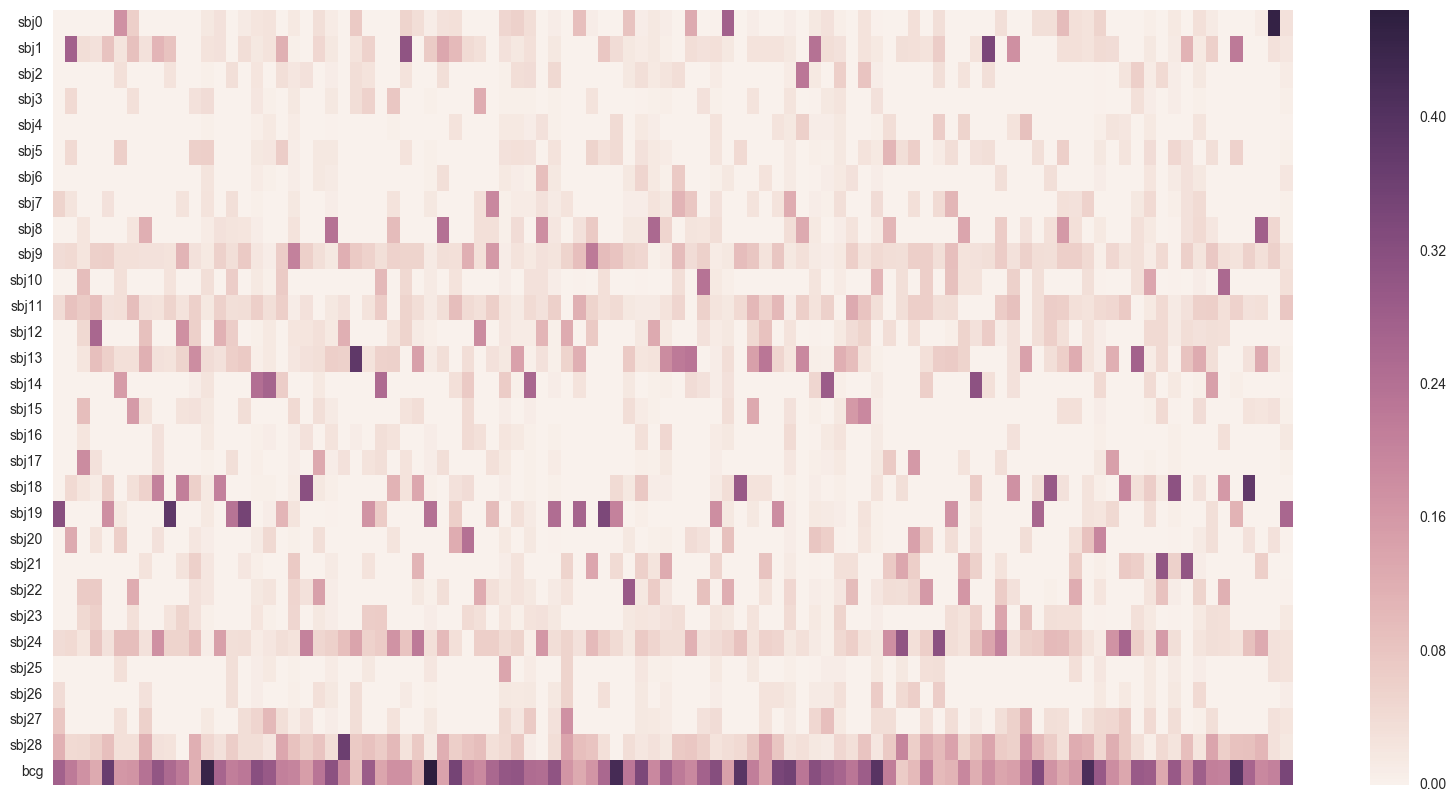

In [627]:
# Ваш код
fig = plt.subplots( figsize=(20, 10))
seaborn.heatmap(theta[theta.columns[0:100]], xticklabels=False)


Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [624]:
# Ваш код
pt = pd.DataFrame(data=theta.sum(axis=1)/sum(theta.sum(axis=1)), columns=["p(t)"])
pt.index = topic_labels
print pt

                                 p(t)
Физика элементарных частиц   0.023452
Физическое материаловедение  0.037559
Средневековье                0.014799
Образование                  0.014564
Разное 1: задача             0.013665
Философия                    0.021130
Культура России              0.018379
Психология                   0.017629
Право                        0.022264
Мозг                         0.029762
Экология                     0.022117
Разное 2: система            0.030484
История                      0.036220
Социология                   0.033276
Астрономия                   0.026625
Экономика                    0.016762
Эмоции                       0.016432
Технологии                   0.011923
Язык                         0.032121
Генетика                     0.033068
Электродинамика              0.025195
Культура                     0.017805
Политика                     0.031884
История России               0.023101
Литература                   0.040189
Математика  

Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

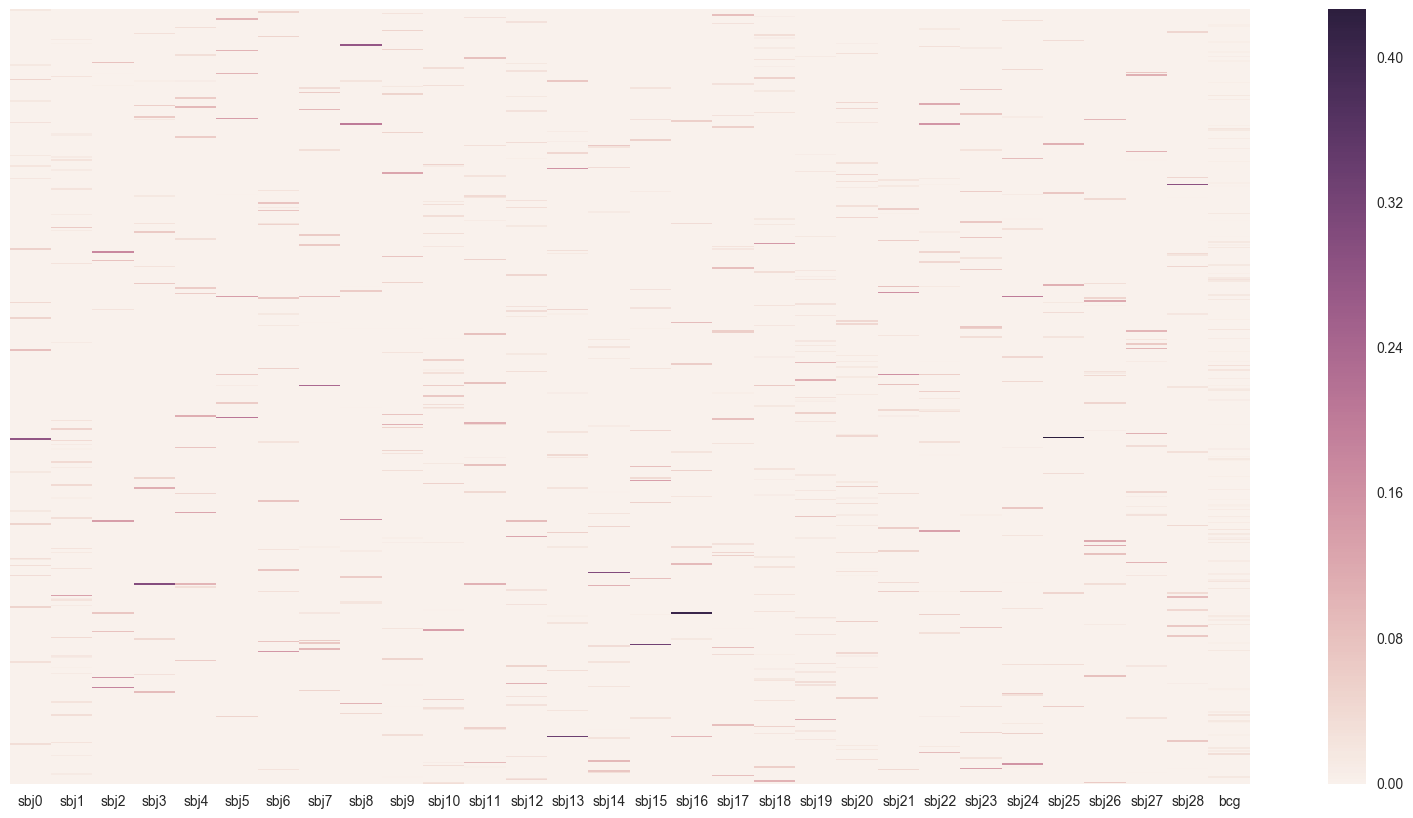

In [616]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(phi_a, yticklabels=False)

In [617]:
for index, row in phi_a.iterrows():
    c=0
    for element in row:
        if element>0.01:
            c= c+1
    if c>2:
        print index
print c

Ян_Левченко
Павел_Нерлер_(Полян)
Гасан_Гусейнов
Алексей_Козырев
Станислав_Дробышевский
Михаил_Киселев
Мария_Фаликман
Михаил_Алексеевский
Михаил_Соколов
1


Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [182]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [644]:
# Ваш код
p_ta = phi_a.get_values() * pt.get_values().reshape((1,30)) / phi_a.get_values().dot(pt.get_values())
mds = MDS(n_components=2, n_init = 1, max_iter = 100, dissimilarity='precomputed')
l = mds.fit_transform(pairwise_distances(p_ta, metric="cosine"))
print l.shape

(539, 2)


Визуализируйте найденные двумерные представления с помощью функции scatter. 

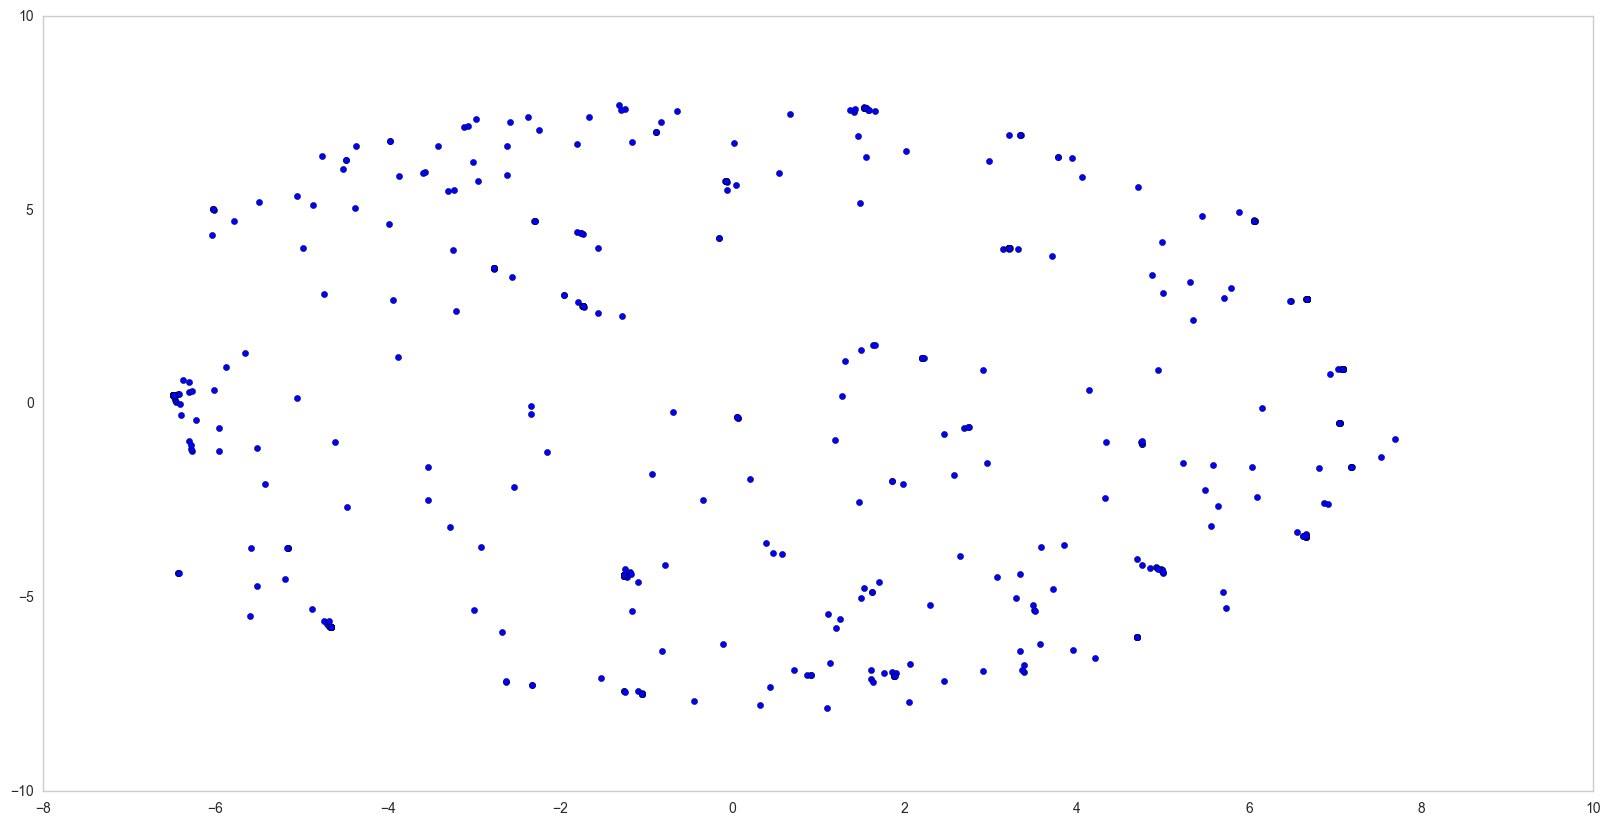

In [643]:
# Ваш код
fig = plt.subplots( figsize=(20, 10))
plt.scatter (l[:,0]*10, l[:,1]*10)

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

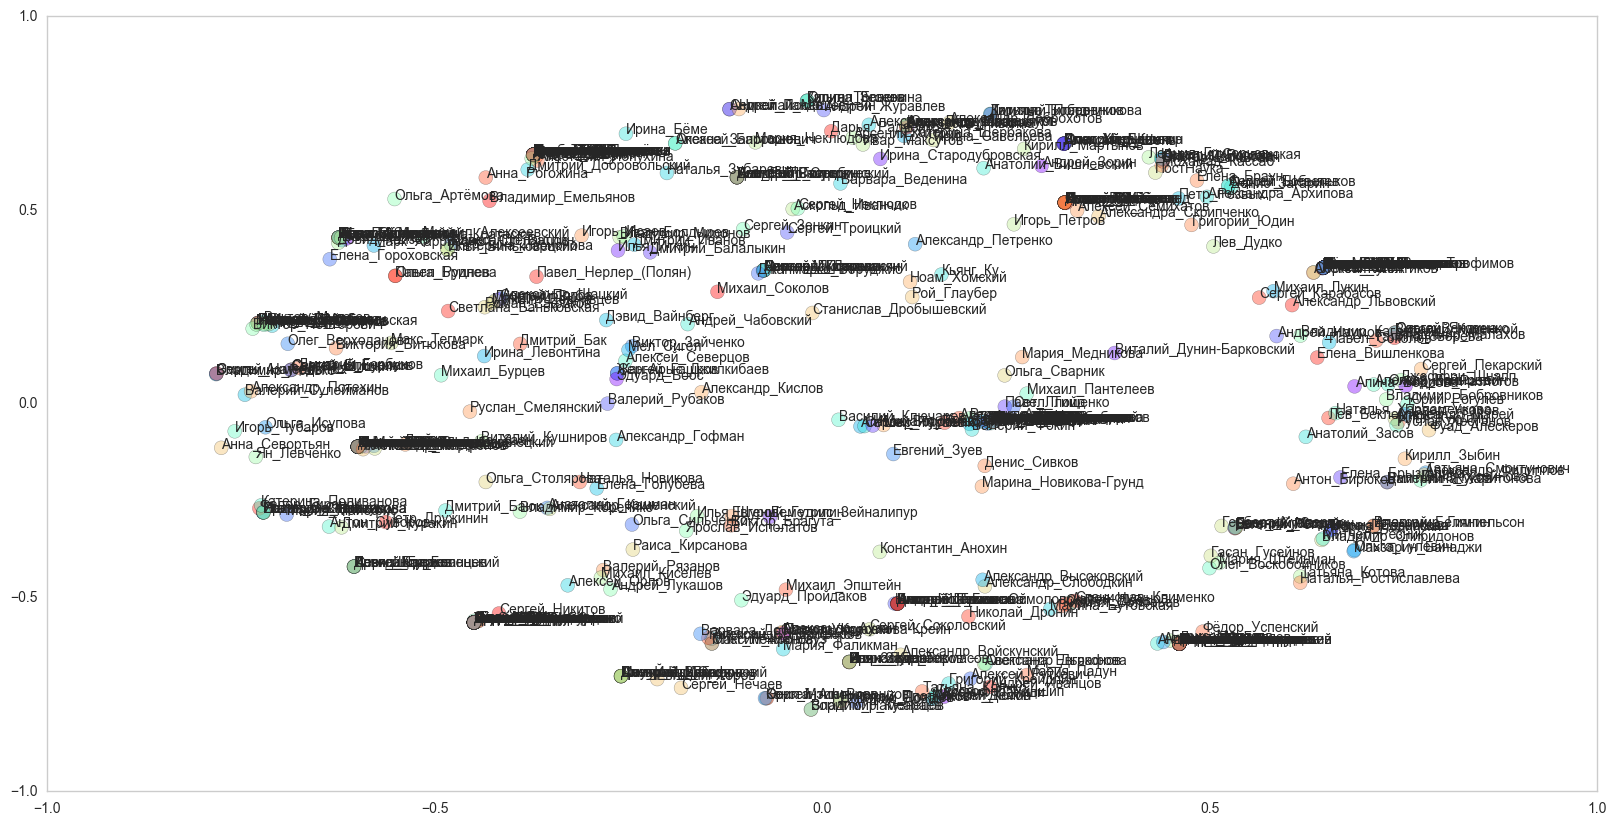

In [671]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
plt.figure(figsize=(20, 10))
plt.scatter(l[:, 0], l[:, 1], s=100, c=colors, cmap=l.argmax(axis=1), alpha=0.4)
for idx, xy in enumerate( l ):
    plt.annotate(phi_a.index[idx], xy=xy)
plt.savefig('authorprofile.pdf')

In [651]:
?plt.annotate

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [672]:
# Ваш код
topdoc = {}
for index, row in theta.iterrows():
    m = row
    r = []
    for i in range (0,10):
        r = np.append(r,m.argmax())
        m = m.drop(m.argmax()) 
    topdoc[index] = r
for word in topdoc ["sbj0"]:
    print word

http://postnauka.ru/video/13043
http://postnauka.ru/video/18870
http://postnauka.ru/video/2945
http://postnauka.ru/video/47952
http://postnauka.ru/video/18873
http://postnauka.ru/video/47826
http://postnauka.ru/video/47947
http://postnauka.ru/video/478
http://postnauka.ru/video/1894
http://postnauka.ru/video/1922


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [673]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [674]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [679]:
# Ваш код
i = 0
for element in sbj_topic_labels:
    display(HTML("<h1>"+element))    
    tokens = model.score_tracker["goodscore1"].last_tokens
    m = []
    print "Ключевые слова темы:",
    for j in range (0,10):    
        print tokens[topic_names[i]][j],
    print
    print "Ключевые документы темы:",
    for word in topdoc [topic_names[i]]:
        print word,
    i = i+1

Ключевые слова темы: теория частица модель взаимодействие три состоять физика сила кварк сильный
Ключевые документы темы: http://postnauka.ru/video/13043 http://postnauka.ru/video/18870 http://postnauka.ru/video/2945 http://postnauka.ru/video/47952 http://postnauka.ru/video/18873 http://postnauka.ru/video/47826 http://postnauka.ru/video/47947 http://postnauka.ru/video/478 http://postnauka.ru/video/1894 http://postnauka.ru/video/1922

 Ключевые слова темы: новый структура материал использовать свойство высокий элемент явление основа температура
Ключевые документы темы: http://postnauka.ru/video/13544 http://postnauka.ru/video/9144 http://postnauka.ru/video/31182 http://postnauka.ru/video/57995 http://postnauka.ru/video/12373 http://postnauka.ru/video/18048 http://postnauka.ru/video/48107 http://postnauka.ru/video/13700 http://postnauka.ru/video/51490 http://postnauka.ru/video/30655

 Ключевые слова темы: жизнь сам именно некий концепция граница над занимать замечательный должно
Ключевые документы темы: http://postnauka.ru/video/50097 http://postnauka.ru/video/42088 http://postnauka.ru/video/53228 http://postnauka.ru/video/12083 http://postnauka.ru/video/5517 http://postnauka.ru/video/13538 http://postnauka.ru/video/21318 http://postnauka.ru/video/22923 http://postnauka.ru/video/33791 http://postnauka.ru/video/3604

 Ключевые слова темы: понимать далее образование общий университет казаться предмет школа опыт признак
Ключевые документы темы: http://postnauka.ru/video/50347 http://postnauka.ru/video/2973 http://postnauka.ru/video/3603 http://postnauka.ru/video/57648 http://postnauka.ru/video/55217 http://postnauka.ru/video/31198 http://postnauka.ru/video/34950 http://postnauka.ru/video/55533 http://postnauka.ru/video/19570 http://postnauka.ru/video/35038

 Ключевые слова темы: задача ребенок решать речь получаться смотреть посмотреть лицо читать понятно
Ключевые документы темы: http://postnauka.ru/video/55068 http://postnauka.ru/video/47548 http://postnauka.ru/video/25101 http://postnauka.ru/video/26633 http://postnauka.ru/video/26207 http://postnauka.ru/video/50793 http://postnauka.ru/video/56042 http://postnauka.ru/video/24451 http://postnauka.ru/video/54744 http://postnauka.ru/video/30267

 Ключевые слова темы: весь время между друг нет потом жить находить действительно представление
Ключевые документы темы: http://postnauka.ru/video/9997 http://postnauka.ru/video/5181 http://postnauka.ru/video/27831 http://postnauka.ru/video/3509 http://postnauka.ru/video/31990 http://postnauka.ru/video/44271 http://postnauka.ru/video/21637 http://postnauka.ru/video/36976 http://postnauka.ru/video/38508 http://postnauka.ru/video/52244

 Ключевые слова темы: говорить конечно там город вот эпоха собственно культурный российский никто
Ключевые документы темы: http://postnauka.ru/video/13156 http://postnauka.ru/video/24279 http://postnauka.ru/video/23470 http://postnauka.ru/video/48112 http://postnauka.ru/video/38510 http://postnauka.ru/video/40004 http://postnauka.ru/video/57318 http://postnauka.ru/video/20394 http://postnauka.ru/video/48478 http://postnauka.ru/video/25253

 Ключевые слова темы: человек ситуация степень хотя создавать вариант цель ответ целое деятельность
Ключевые документы темы: http://postnauka.ru/video/7767 http://postnauka.ru/video/56618 http://postnauka.ru/video/15341 http://postnauka.ru/video/22722 http://postnauka.ru/video/47457 http://postnauka.ru/video/9042 http://postnauka.ru/video/11361 http://postnauka.ru/video/51382 http://postnauka.ru/video/46431 http://postnauka.ru/video/48994

 Ключевые слова темы: кто отношение право здесь вещь действие закон правило перед интерес
Ключевые документы темы: http://postnauka.ru/video/38009 http://postnauka.ru/video/16822 http://postnauka.ru/video/42221 http://postnauka.ru/video/34414 http://postnauka.ru/video/31688 http://postnauka.ru/video/49455 http://postnauka.ru/video/31666 http://postnauka.ru/video/39998 http://postnauka.ru/video/17825 http://postnauka.ru/video/42220

 Ключевые слова темы: происходить рассказывать проблема вид место данные уровень развиваться поведение либо
Ключевые документы темы: http://postnauka.ru/video/7753 http://postnauka.ru/video/8661 http://postnauka.ru/video/457 http://postnauka.ru/video/19069 http://postnauka.ru/video/16821 http://postnauka.ru/video/46562 http://postnauka.ru/video/5179 http://postnauka.ru/video/24182 http://postnauka.ru/video/7770 http://postnauka.ru/video/6758

 Ключевые слова темы: условие изменение животное эволюция вода составлять назад робот нейрон зона
Ключевые документы темы: http://postnauka.ru/video/30673 http://postnauka.ru/video/9861 http://postnauka.ru/video/49437 http://postnauka.ru/video/8953 http://postnauka.ru/video/19071 http://postnauka.ru/video/34424 http://postnauka.ru/video/26232 http://postnauka.ru/video/49262 http://postnauka.ru/video/24245 http://postnauka.ru/video/12971

 Ключевые слова темы: система разный чем процесс видеть объект раз информация доктор память
Ключевые документы темы: http://postnauka.ru/video/9389 http://postnauka.ru/video/56052 http://postnauka.ru/video/5882 http://postnauka.ru/video/57336 http://postnauka.ru/video/3645 http://postnauka.ru/video/48109 http://postnauka.ru/video/54916 http://postnauka.ru/video/7032 http://postnauka.ru/video/53949 http://postnauka.ru/video/7283

 Ключевые слова темы: история век государство война исторический период народ великий европа историк
Ключевые документы темы: http://postnauka.ru/video/9876 http://postnauka.ru/video/24039 http://postnauka.ru/video/9968 http://postnauka.ru/video/24034 http://postnauka.ru/video/7785 http://postnauka.ru/video/3348 http://postnauka.ru/video/32637 http://postnauka.ru/video/35041 http://postnauka.ru/video/24030 http://postnauka.ru/video/21100

 Ключевые слова темы: мир социальный понятие исследование общество знание сегодня научный иной рамка
Ключевые документы темы: http://postnauka.ru/video/10783 http://postnauka.ru/video/17491 http://postnauka.ru/video/23361 http://postnauka.ru/video/3380 http://postnauka.ru/video/6380 http://postnauka.ru/video/14295 http://postnauka.ru/video/17486 http://postnauka.ru/video/9148 http://postnauka.ru/video/5198 http://postnauka.ru/video/15345

 Ключевые слова темы: звезда земля галактика масса планета черный размер скорость вселенная дыра
Ключевые документы темы: http://postnauka.ru/video/2971 http://postnauka.ru/video/6673 http://postnauka.ru/video/17780 http://postnauka.ru/video/58574 http://postnauka.ru/video/57338 http://postnauka.ru/video/31695 http://postnauka.ru/video/31193 http://postnauka.ru/video/23502 http://postnauka.ru/video/17779 http://postnauka.ru/video/30015

 Ключевые слова темы: решение страна хотеть принимать внимание проект экономический означать взгляд американский
Ключевые документы темы: http://postnauka.ru/video/53415 http://postnauka.ru/video/13152 http://postnauka.ru/video/5465 http://postnauka.ru/video/43679 http://postnauka.ru/video/16182 http://postnauka.ru/video/51488 http://postnauka.ru/video/28284 http://postnauka.ru/video/14280 http://postnauka.ru/video/12149 http://postnauka.ru/video/20875

 Ключевые слова темы: вопрос знать сказать делать хороший пытаться что-то предлагать собственный факт
Ключевые документы темы: http://postnauka.ru/video/22892 http://postnauka.ru/video/2946 http://postnauka.ru/video/56306 http://postnauka.ru/video/9729 http://postnauka.ru/video/17487 http://postnauka.ru/video/9865 http://postnauka.ru/video/48623 http://postnauka.ru/video/38499 http://postnauka.ru/video/28278 http://postnauka.ru/video/48493

 Ключевые слова темы: число сделать сеть мой рассматривать множество ошибка набор необходимо сложность
Ключевые документы темы: http://postnauka.ru/video/32901 http://postnauka.ru/video/7514 http://postnauka.ru/video/26607 http://postnauka.ru/video/8313 http://postnauka.ru/video/47810 http://postnauka.ru/video/55303 http://postnauka.ru/video/10380 http://postnauka.ru/video/8632 http://postnauka.ru/video/32918 http://postnauka.ru/video/31200

 Ключевые слова темы: язык слово русский территория словарь христианский восток перевод письменность письмо
Ключевые документы темы: http://postnauka.ru/video/7755 http://postnauka.ru/video/13041 http://postnauka.ru/video/27825 http://postnauka.ru/video/51380 http://postnauka.ru/video/8964 http://postnauka.ru/video/53169 http://postnauka.ru/video/16157 http://postnauka.ru/video/7525 http://postnauka.ru/video/53171 http://postnauka.ru/video/55301

 Ключевые слова темы: клетка организм ген днк белок молекула биологический болезнь генетический последовательность
Ключевые документы темы: http://postnauka.ru/video/5915 http://postnauka.ru/video/5390 http://postnauka.ru/video/19436 http://postnauka.ru/video/10475 http://postnauka.ru/video/27434 http://postnauka.ru/video/10754 http://postnauka.ru/video/17051 http://postnauka.ru/video/35461 http://postnauka.ru/video/11628 http://postnauka.ru/video/32881

 Ключевые слова темы: энергия поле состояние квантовый свет эксперимент эффект атом магнитный волна
Ключевые документы темы: http://postnauka.ru/video/25875 http://postnauka.ru/video/24434 http://postnauka.ru/video/19457 http://postnauka.ru/video/51174 http://postnauka.ru/video/21662 http://postnauka.ru/video/26515 http://postnauka.ru/video/49431 http://postnauka.ru/video/19509 http://postnauka.ru/video/58741 http://postnauka.ru/video/14283

 Ключевые слова темы: культура смысл философия принцип женщина философский семья понимание входить массовый
Ключевые документы темы: http://postnauka.ru/video/2529 http://postnauka.ru/video/12738 http://postnauka.ru/video/7068 http://postnauka.ru/video/12740 http://postnauka.ru/video/46317 http://postnauka.ru/video/23834 http://postnauka.ru/video/46429 http://postnauka.ru/video/34955 http://postnauka.ru/video/1507 http://postnauka.ru/video/9728

 Ключевые слова темы: его год политический идея власть революция писать начинаться политика бог
Ключевые документы темы: http://postnauka.ru/video/34941 http://postnauka.ru/video/43001 http://postnauka.ru/video/25882 http://postnauka.ru/video/42993 http://postnauka.ru/video/48492 http://postnauka.ru/video/11634 http://postnauka.ru/video/58542 http://postnauka.ru/video/54175 http://postnauka.ru/video/22975 http://postnauka.ru/video/23472

 Ключевые слова темы: свой становиться первый россия поскольку советский считать род проводить выходить
Ключевые документы темы: http://postnauka.ru/video/34413 http://postnauka.ru/video/30261 http://postnauka.ru/video/41680 http://postnauka.ru/video/46939 http://postnauka.ru/video/34963 http://postnauka.ru/video/47816 http://postnauka.ru/video/41348 http://postnauka.ru/video/36810 http://postnauka.ru/video/33941 http://postnauka.ru/video/40218

 Ключевые слова темы: наука себя современный текст форма кандидат век известный древний традиция
Ключевые документы темы: http://postnauka.ru/video/14297 http://postnauka.ru/video/7551 http://postnauka.ru/video/5394 http://postnauka.ru/video/7083 http://postnauka.ru/video/12290 http://postnauka.ru/video/12156 http://postnauka.ru/video/48114 http://postnauka.ru/video/5876 http://postnauka.ru/video/21631 http://postnauka.ru/video/13181

 Ключевые слова темы: какой-то оказываться момент пространство описывать классический движение следующий гипотеза сначала
Ключевые документы темы: http://postnauka.ru/video/55069 http://postnauka.ru/video/25326 http://postnauka.ru/video/7218 http://postnauka.ru/video/18085 http://postnauka.ru/video/36804 http://postnauka.ru/video/1817 http://postnauka.ru/video/11363 http://postnauka.ru/video/18086 http://postnauka.ru/video/25278 http://postnauka.ru/video/1856

 Ключевые слова темы: она часть оно значение нужный анализ всегда скажем совсем во-первых
Ключевые документы темы: http://postnauka.ru/video/31684 http://postnauka.ru/video/49866 http://postnauka.ru/video/30601 http://postnauka.ru/video/43843 http://postnauka.ru/video/26616 http://postnauka.ru/video/24286 http://postnauka.ru/video/37978 http://postnauka.ru/video/57127 http://postnauka.ru/video/46559 http://postnauka.ru/video/36242

 Ключевые слова темы: наш иметь более два несколько довольно тип результат мало определять
Ключевые документы темы: http://postnauka.ru/video/7731 http://postnauka.ru/video/6725 http://postnauka.ru/video/11548 http://postnauka.ru/video/59457 http://postnauka.ru/video/23969 http://postnauka.ru/video/6608 http://postnauka.ru/video/53949 http://postnauka.ru/video/23500 http://postnauka.ru/video/1837 http://postnauka.ru/video/38512

 Ключевые слова темы: какой образ развитие роль конец книга начало ученый каков зрение
Ключевые документы темы: http://postnauka.ru/video/9429 http://postnauka.ru/video/10779 http://postnauka.ru/video/7074 http://postnauka.ru/video/39723 http://postnauka.ru/video/7351 http://postnauka.ru/video/3405 http://postnauka.ru/video/2530 http://postnauka.ru/video/7854 http://postnauka.ru/video/9692 http://postnauka.ru/video/12156


In [678]:
?display

In [497]:
1+1

2

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 